In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import glob
import skimage
import skimage.io

In [2]:
NATURE_PATH = 'nature/'
PEOPLE_PATH = 'people/'
FOOD_PATH = 'food/'

DATA_PATH = './data/'

# Preprocess data and write it to several TFRecord files

In [3]:
BytesList = tf.train.BytesList
FloatList = tf.train.FloatList
Int64List = tf.train.Int64List
Feature = tf.train.Feature
Features = tf.train.Features
Example = tf.train.Example
FeatureList = tf.train.FeatureList
FeatureLists = tf.train.FeatureLists
SequenceExample = tf.train.SequenceExample

def load_images(root, path):
    imagepaths = glob.glob(root + path + '*')

    images = [skimage.io.imread(path) for path in imagepaths]
    images = [image[:,:,:3] for image in images] # only RGB
    return images

def preprocess_image(image):
    image = tf.constant(image, dtype=tf.float32)
    image = tf.image.resize(image, (224,224))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image

def to_protobuf(image, label):
    image_data = tf.io.serialize_tensor(image)
    return Example(
        features=Features(
            feature={
                'image': Feature(bytes_list=BytesList(value=[image_data.numpy()])),
                'label': Feature(int64_list=Int64List(value=[label]))
            }))

def to_tfrecord(data, root, filename):
    
    with tf.io.TFRecordWriter(root + filename) as writer:
        for instance in data:
            writer.write(instance.SerializeToString())

def preprocess_data(root, path, class_label, output_filename):
    images = load_images(root, path)
    images = [preprocess_image(image) for image in images]
    data = [to_protobuf(image, class_label) for image in images]
    
    to_tfrecord(data, root, output_filename)

NATURE_LABEL = 0
PEOPLE_LABEL = 1
FOOD_LABEL = 2
NATURE_FILENAME = 'nature_instances.tfrecord'
PEOPLE_FILENAME = 'people_instances.tfrecord'
FOOD_FILENAME = 'food_instances.tfrecord'

preprocess_data(DATA_PATH, NATURE_PATH, NATURE_LABEL, NATURE_FILENAME)
preprocess_data(DATA_PATH, PEOPLE_PATH, PEOPLE_LABEL, PEOPLE_FILENAME)
preprocess_data(DATA_PATH, FOOD_PATH, FOOD_LABEL, FOOD_FILENAME)

# Creat input pipeline

In [7]:
def parse_tfrecord(tfrecord):
    feature_descriptions = {
        "image": tf.io.FixedLenFeature([], tf.string, default_value=""),
        "label": tf.io.FixedLenFeature([], tf.int64, default_value=-1)
    }
    protobuf = tf.io.parse_single_example(tfrecord, feature_descriptions)
    image = tf.io.parse_tensor(protobuf['image'], out_type=tf.float32)
    
    return image, protobuf['label']


filepaths = [DATA_PATH + NATURE_FILENAME, 
             DATA_PATH + PEOPLE_FILENAME,
             DATA_PATH + FOOD_FILENAME]

dataset_files = tf.data.Dataset.list_files(filepaths, seed=42)
n_readers = 3
dataset = dataset_files.interleave(
                    lambda filepath: tf.data.TFRecordDataset(filepath),
                    cycle_length=n_readers,
                    num_parallel_calls=n_readers)

dataset = dataset.map(parse_tfrecord, num_parallel_calls=6)

# Split train and test dataset (verify correctness)

zeros = 0
ones = 0
twos = 0

for x, y in dataset.take(90):
    label = y.numpy()
    
    if label == 0:
        zeros += 1
    elif label == 1:
        ones += 1
    elif label == 2:
        twos += 1
    else:
        print("Error Label: " + str(label))
        
assert(zeros == 30 and ones == 30 and twos == 30)

test_dataset = dataset.take(60).batch(32)
train_dataset = dataset.skip(60).batch(32).shuffle(390).prefetch(1)

tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)


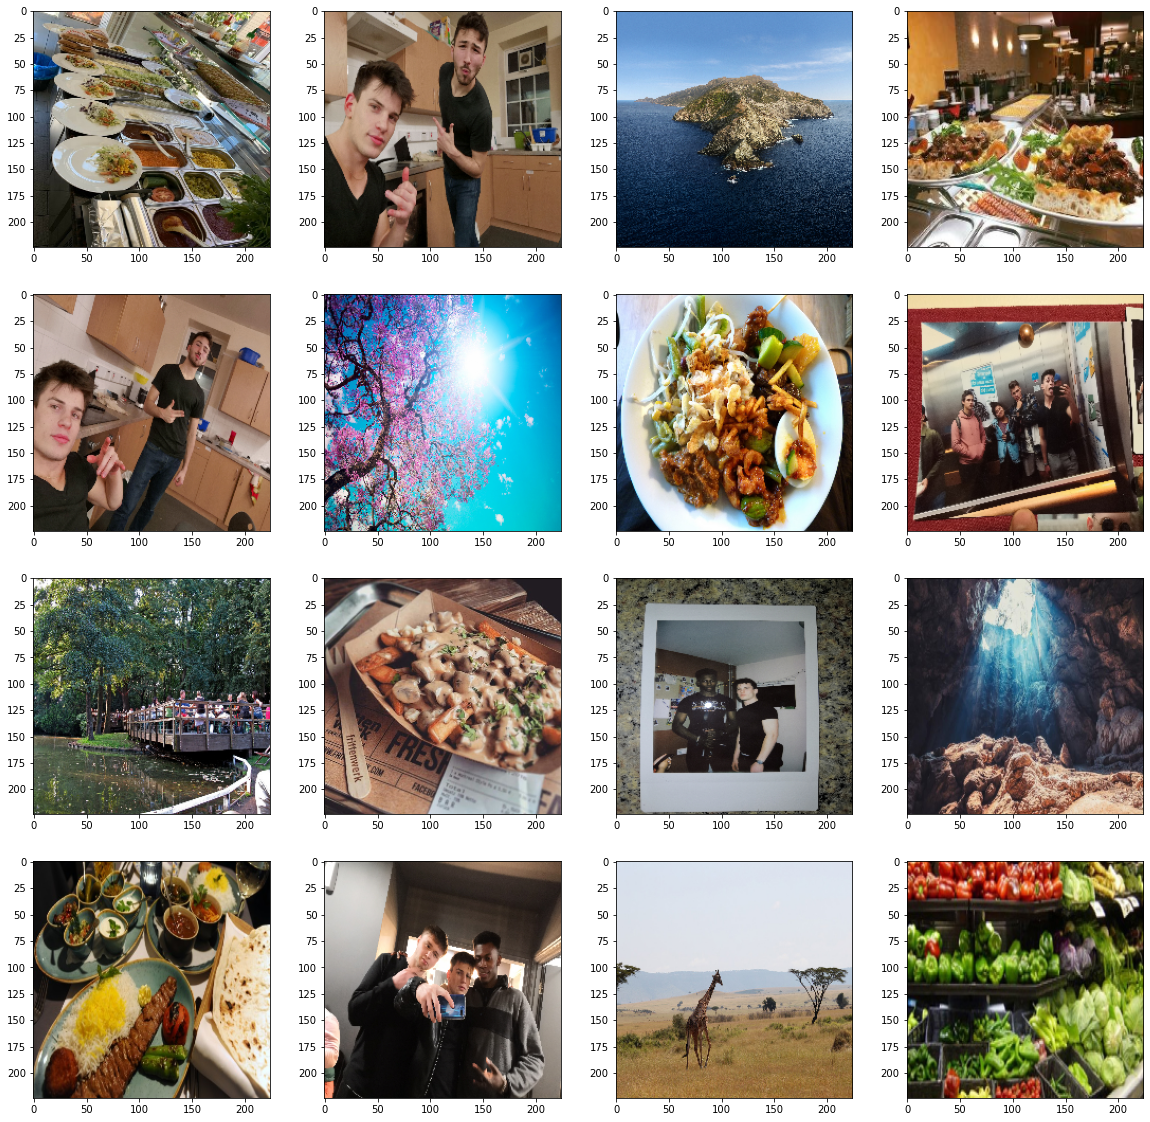

In [6]:
plt.figure(figsize=(20, 20))

for (x, y), index in zip(test_dataset.unbatch().take(16), range(1, 100)):
    #print(x.shape)
    #print(np.amin(x), np.amax(x))
    x = (x + 1.) /2.
    print(y)
    plt.subplot(4, 4, index)
    plt.imshow(x)
    
test_dataset = dataset.take(60) # Reset the Dataset after iterating over it

# Create the model using Transfer Learning

In [13]:
N_CLASSES = 3

base_model = keras.applications.mobilenet_v2.MobileNetV2(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(N_CLASSES, activation="softmax")(avg)
model = keras.Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False
    
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=keras.optimizers.Nadam(0.002),
              metrics='accuracy')

model.summary()

for layer in model.layers:
    print(layer.output_shape)

9412608/9406464 [==============================] - 1s 0us/step
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_6[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, None, None, 3 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, None, None, 3 128         Conv1[0][0]                      
_____________________________

In [14]:
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=(10,10))
earlystopping = tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)

history = model.fit(train_dataset, epochs=10, validation_data=(test_dataset),
                   metrics=[tensorboard, earlystopping])

Epoch 1/10
13/13 [==============================] - 44s 3s/step - loss: 0.6851 - accuracy: 0.6872 - val_loss: 0.2462 - val_accuracy: 0.9500
Epoch 2/10
13/13 [==============================] - 47s 4s/step - loss: 0.2002 - accuracy: 0.9667 - val_loss: 0.1005 - val_accuracy: 0.9500
Epoch 3/10
13/13 [==============================] - 47s 4s/step - loss: 0.0960 - accuracy: 0.9897 - val_loss: 0.0566 - val_accuracy: 1.0000
Epoch 4/10
13/13 [==============================] - 41s 3s/step - loss: 0.0644 - accuracy: 0.9923 - val_loss: 0.0386 - val_accuracy: 1.0000
Epoch 5/10
13/13 [==============================] - 43s 3s/step - loss: 0.0459 - accuracy: 0.9974 - val_loss: 0.0339 - val_accuracy: 1.0000
Epoch 6/10
13/13 [==============================] - 43s 3s/step - loss: 0.0338 - accuracy: 1.0000 - val_loss: 0.0290 - val_accuracy: 1.0000
Epoch 7/10
13/13 [==============================] - 43s 3s/step - loss: 0.0283 - accuracy: 1.0000 - val_loss: 0.0242 - val_accuracy: 1.0000
Epoch 8/10
13/13 [==

# Save the model

In [15]:
model.save("model.h5")

In [16]:
loaded_model = keras.models.load_model("model.h5")

loaded_model.evaluate(test_dataset) # Verify

2/2 [==============================] - 1s 312ms/step - loss: 0.0185 - accuracy: 1.0000


[0.0185115784406662, 1.0]

# Final Test

In [42]:
TEST_PATH = 'test/'
DATA_PATH = './data/'

images = load_images(DATA_PATH, TEST_PATH)
images = [preprocess_image(image) for image in images]

images = np.array(images)

In [43]:
preds = model.predict(images)
label_preds = np.argmax(preds, axis=1)

In [44]:
labels = ['nature', 'person', 'food']
NATURE_LABEL, PEOPLE_LABEL, FOOD_LABEL

(0, 1, 2)

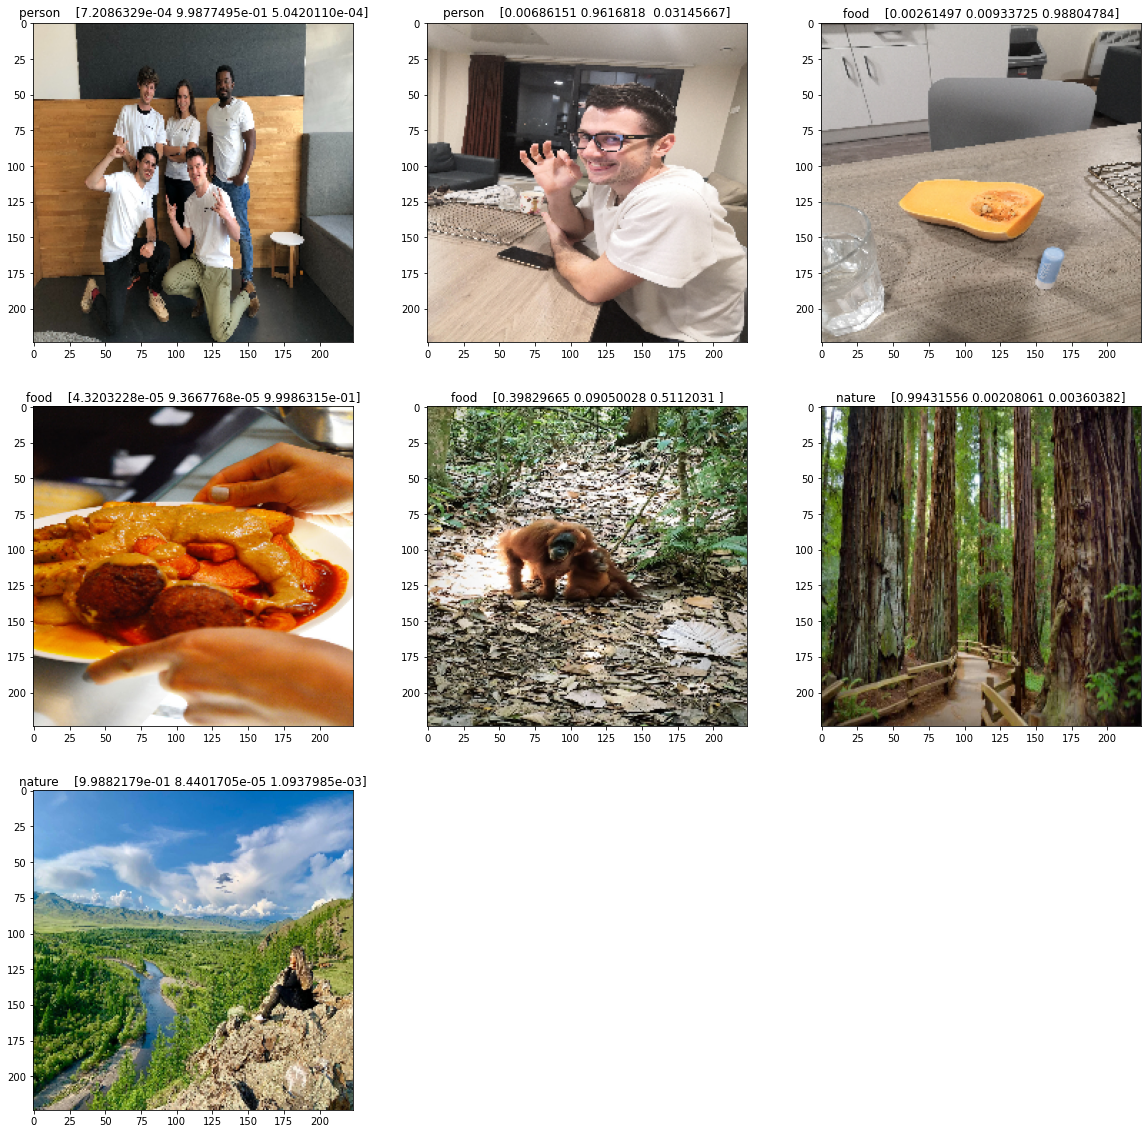

In [46]:
plt.figure(figsize=(20, 20))

for image, label, probabilities, index in zip(images, label_preds, preds, range(1,10)):
    image = (image + 1.) /2.

    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title(labels[label] + '    ' + str(probabilities))